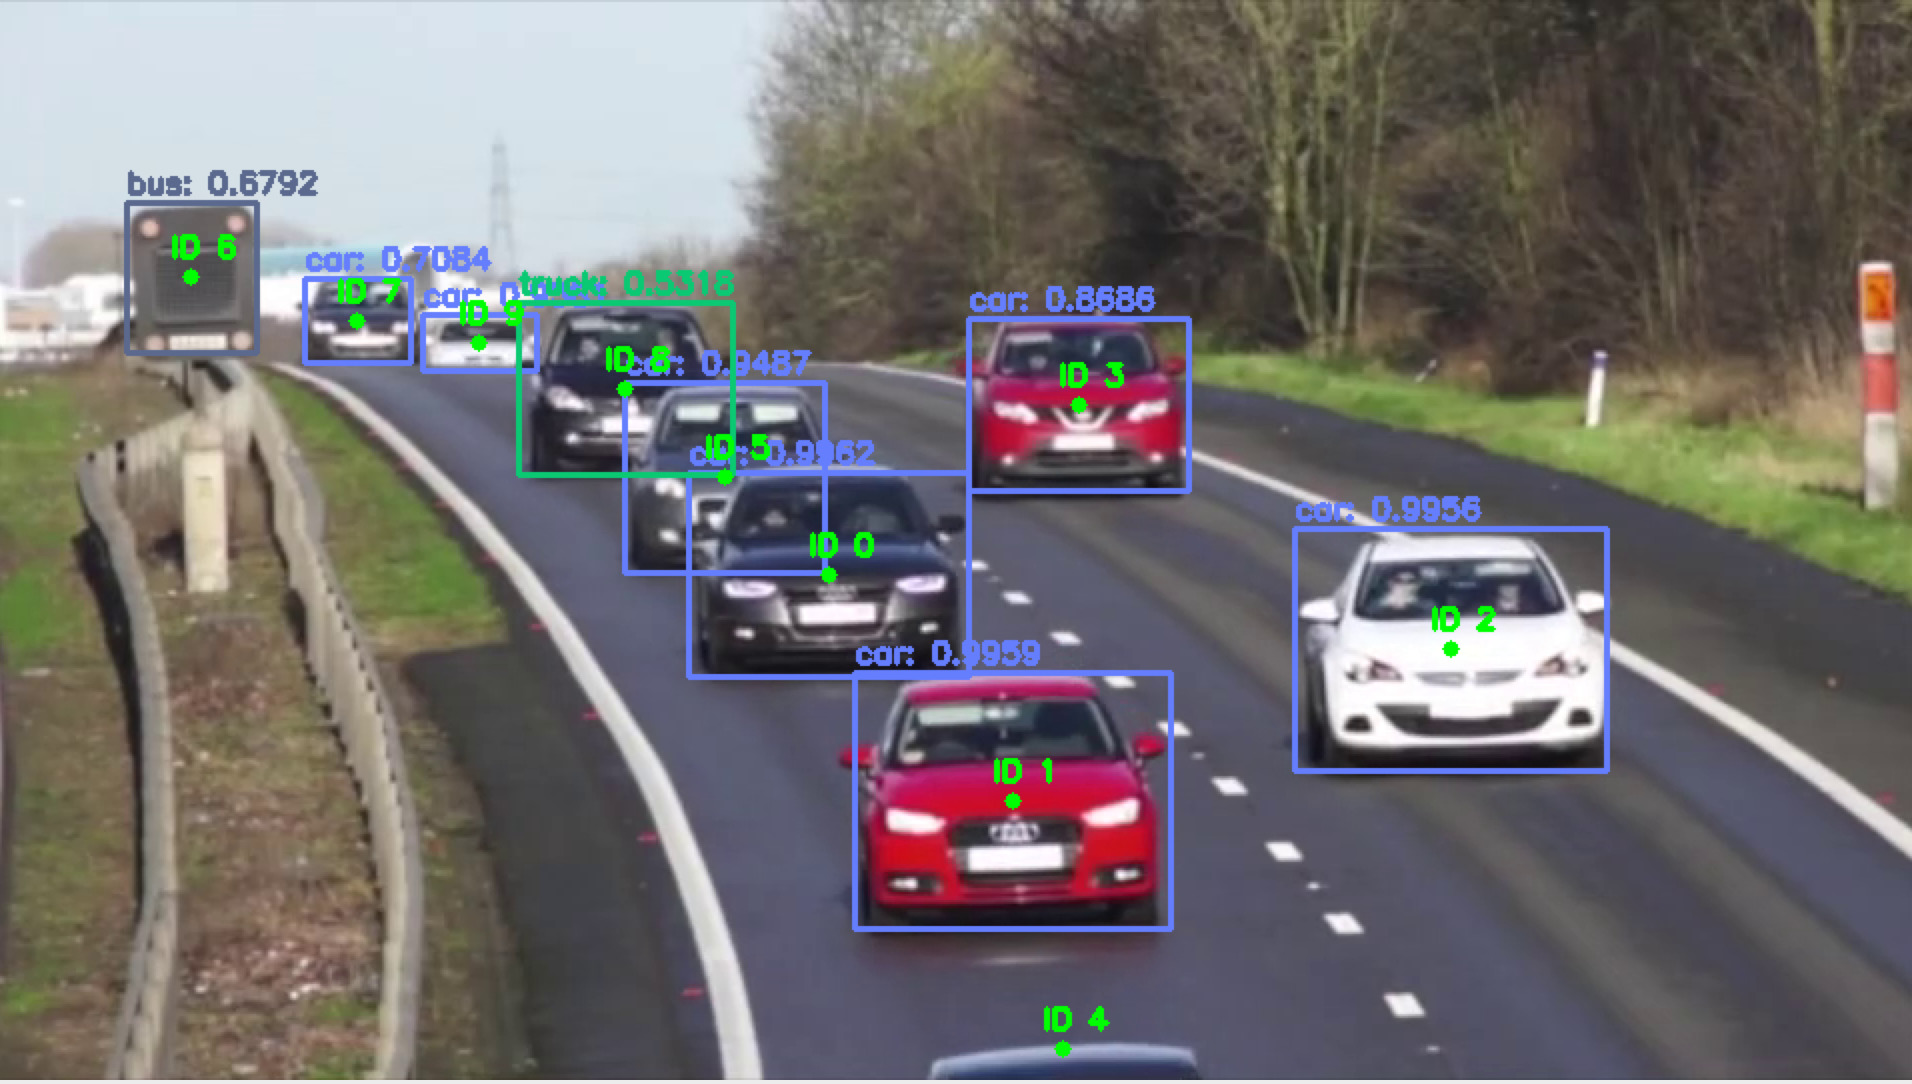

In [1]:
import cv2 as cv2
from scipy.spatial import distance
import numpy as np
import time
from collections import OrderedDict

In [2]:
#Objeleri takip etmek için tracker class

class Tracker:
    def __init__(self, maxLost = 30):           # maxLost: maximum object lost counted when the object is being tracked
        self.nextObjectID = 0                   # ID , bir sonraki nesne için
        self.objects = OrderedDict()            # stores ID:Locations
        self.lost = OrderedDict()               # stores ID:Lost_count
        
        self.maxLost = maxLost                  # maximum number of frames object was not detected.
        
    def addObject(self, new_object_location): # Objenin değişen konumunu ekler
        self.objects[self.nextObjectID] = new_object_location    # store new object location
        self.lost[self.nextObjectID] = 0                         # initialize frame_counts for when new object is undetected
        
        self.nextObjectID += 1
    
    def removeObject(self, objectID):                          # Frame'de araç yoksa sil
        del self.objects[objectID]
        del self.lost[objectID]
    
    @staticmethod
    def getLocation(bounding_box):
        xlt, ylt, xrb, yrb = bounding_box
        return (int((xlt + xrb) / 2.0), int((ylt + yrb) / 2.0))
    
    def update(self,  detections):
        
        if len(detections) == 0:   # if no object detected in the frame
            lost_ids = list(self.lost.keys())
            for objectID in lost_ids:
                self.lost[objectID] +=1
                if self.lost[objectID] > self.maxLost: self.removeObject(objectID)
            
            return self.objects
        
        # current object locations
        new_object_locations = np.zeros((len(detections), 2), dtype="int")     
        
        for (i, detection) in enumerate(detections): new_object_locations[i] = self.getLocation(detection)
            
        if len(self.objects)==0:
            for i in range(0, len(detections)): self.addObject(new_object_locations[i])
        else:
            objectIDs = list(self.objects.keys())
            previous_object_locations = np.array(list(self.objects.values()))
            
            # Eski ve yeni konum arasındaki mesafe
            D = distance.cdist(previous_object_locations, new_object_locations) 
            
            row_idx = D.min(axis=1).argsort()   # (minimum distance of previous from current).sort_as_per_index
            
            cols_idx = D.argmin(axis=1)[row_idx]   # index of minimum distance of previous from current
            
            assignedRows, assignedCols = set(), set()
            
            for (row, col) in zip(row_idx, cols_idx):
                
                if row in assignedRows or col in assignedCols:
                    continue
                
                objectID = objectIDs[row]
                self.objects[objectID] = new_object_locations[col]
                self.lost[objectID] = 0
                
                assignedRows.add(row)
                assignedCols.add(col)
                
            rows = set(range(0, D.shape[0])).difference(assignedRows)
            cols = set(range(0, D.shape[1])).difference(assignedCols)
            
            
            if D.shape[0]>=D.shape[1]:
                for row in rows:
                    objectID = objectIDs[row]
                    self.lost[objectID] += 1
                    
                    if self.lost[objectID] > self.maxLost:
                        self.removeObject(objectID)
                        
            else:
                for col in cols:
                    self.addObject(new_object_locations[col])
            
        return self.objects

In [3]:
#YOLOMODEL

yolomodel = {"config_path":"/Users/senauzun/models/research/object_detection/darknet/cfg/yolov3.cfg",
              "model_weights_path":"/Users/senauzun/models/research/object_detection/darknet/yolov3.weights",
              "coco_names":"/Users/senauzun/models/research/object_detection/darknet/data/coco.names",
              "confidence_threshold": 0.5,
              "threshold":0.3
             }


#YolOMODEL 'i okumak için function
#Reads a network model stored in Darknet model files
net = cv2.dnn.readNetFromDarknet(yolomodel["config_path"], yolomodel["model_weights_path"])
labels = open(yolomodel["coco_names"]).read().strip().split("\n")

In [4]:
layer_names = net.getLayerNames() # Truck,bus ya da car
layer_names = [layer_names[i[0]-1] 
        
        for i in net.getUnconnectedOutLayers()]
print(layer_names)

bbox_colors = np.random.randint(0, 255, size=(len(labels), 2))

['yolo_82', 'yolo_94', 'yolo_106']


In [5]:
maxLost = 5   # maximum number of object losts counted when the object is being tracked
tracker = Tracker(maxLost = maxLost)

In [6]:
#Video path ve VideoCapture

video_src = "/Users/senauzun/training_video.mp4"
cap = cv2.VideoCapture(video_src)

In [ ]:
(H, W) = (None, None)  # yükseklik/genişlik

font = cv2.FONT_HERSHEY_SIMPLEX
starting_time= time.time()
frame_id = 0


while(True):
    
    #Frameleri oku
    ok, image = cap.read()
    frame_id+=1
    
    if not ok:
        print("Cannot read the video feed.")
        break
    
    if W is None or H is None: (H, W) = image.shape[:2] #derinlik olmadan şekil ver
        
    #Videodan okudugu frameleri 4 boyutlu yorumla
    
    #DNN derin sinir ağı  modülü
    #Görüntüleri alır ve işler böylece sınıflandırır
    #(image,scale,boyut,red/blue değerleri=F ya da T)
    blob = cv2.dnn.blobFromImage(image, 1 / 255.0, (416, 416), swapRB=True, crop=False)
    
    #Girdiyi önceden eğitilmiş derin öğrenme ağına atıp her biri için 
    #tahmini çıktı olasılıklarını hesapla
    net.setInput(blob)
    detections_layer = net.forward(layer_names)   # Object Detection modelini kullanarak objeleri
                                                  # tanır
    
    detections_bbox = []     # bounding box for detections
    
    boxes, confidences, classIDs = [], [], []
    #katman çıktılarının her biri için dön
    for out in detections_layer:
        #Detect edilen objeler içinde
        for detection in out:
            #label ve olasılık yüzdelerini çıkar
            scores = detection[5:]
            classID = np.argmax(scores)
            confidence = scores[classID]
            
            if confidence > 0.68: #yolomodel['confidence_threshold'] yani güven skoru
               #Detect edilen nesnenin indeksi cıkartılır ve 
                # bounding box için (x,y) göre ayarlanır
                box = detection[0:4] * np.array([W, H, W, H])
                (centerX, centerY, width, height) = box.astype("int")
                
                #orta noktayı belirle
                x = int(centerX - (width / 2))
                y = int(centerY - (height / 2))
                
                # %kac truck ya da araba
                # bounding box sınırları
                #class ID'si.
                #Aslında listeyi update ediyorum
                boxes.append([x, y, int(width), int(height)])
                confidences.append(float(confidence))
                classIDs.append(classID)
    
    idxs = cv2.dnn.NMSBoxes(boxes, confidences, yolomodel["confidence_threshold"], yolomodel["threshold"])
    
    #Detect edilen en az bir nesne varsa
    if len(idxs)>0:
        for i in idxs.flatten():
            #Koordinatlarını ver
            (x, y) = (boxes[i][0], boxes[i][1])
            (w, h) = (boxes[i][2], boxes[i][3])
            
            #En son detect edilen objeleri tutar
            detections_bbox.append((x, y, x+w, y+h))
            
            #Bounding box çiz ve isimlendir
            clr = [int(c) for c in bbox_colors[classIDs[i]]]
            cv2.rectangle(image, (x, y), (x+w, y+h), clr, 1)
            cv2.putText(image, "{}: {:.4f}".format(labels[classIDs[i]], confidences[i]),
                      (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, clr, 1)
            
    # update tracker based on the newly detected objects
    objects = tracker.update(detections_bbox)  
    
    for (objectID, centroid) in objects.items():
        text = "ID {}".format(objectID)
        cv2.putText(image, text, (centroid[0] - 10, centroid[1] - 10), cv2.FONT_HERSHEY_SIMPLEX,
                    0.5, (0, 255, 0), 1)
        cv2.circle(image, (centroid[0], centroid[1]), 4, (0, 255, 0), -1)
       
    #FPS hesapla
    elapsed_time = time.time() - starting_time
    fps=frame_id/elapsed_time
    cv2.putText(image,"FPS:"+str(round(fps,2)),(10,50),font,2,(0,0,0),1)
    cv2.putText(image,"Count:"+str(len(objects)),(10,100),font,2,(0,0,0),1)
        
    cv2.imshow("Video", image)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
        
cap.release()
cv2.destroyWindow("image")